In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = "/content/drive/MyDrive/Colab Notebooks/APRENDIZAJE2"

In [ ]:
#CARGA DE LIBRERIAS Y FICHERO DE DATOS
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics import silhouette_samples, silhouette_score

tintos = pd.read_csv(f"{base_path}/train_red.csv")

In [ ]:
#DISTRIBUCION DE LOS DATOS
tintos.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000
mean,8.309539,0.530731,0.268757,2.546755,0.087228,15.847146,46.465598,0.996737,3.311900,0.656747,10.431496
std,1.734255,0.179058,0.196030,1.403274,0.047477,10.426840,33.225000,0.001874,0.153572,0.171736,1.077012
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.370000,8.400000
25%,7.100000,0.400000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,38.000000,0.996740,3.310000,0.620000,10.100000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997825,3.400000,0.730000,11.100000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000


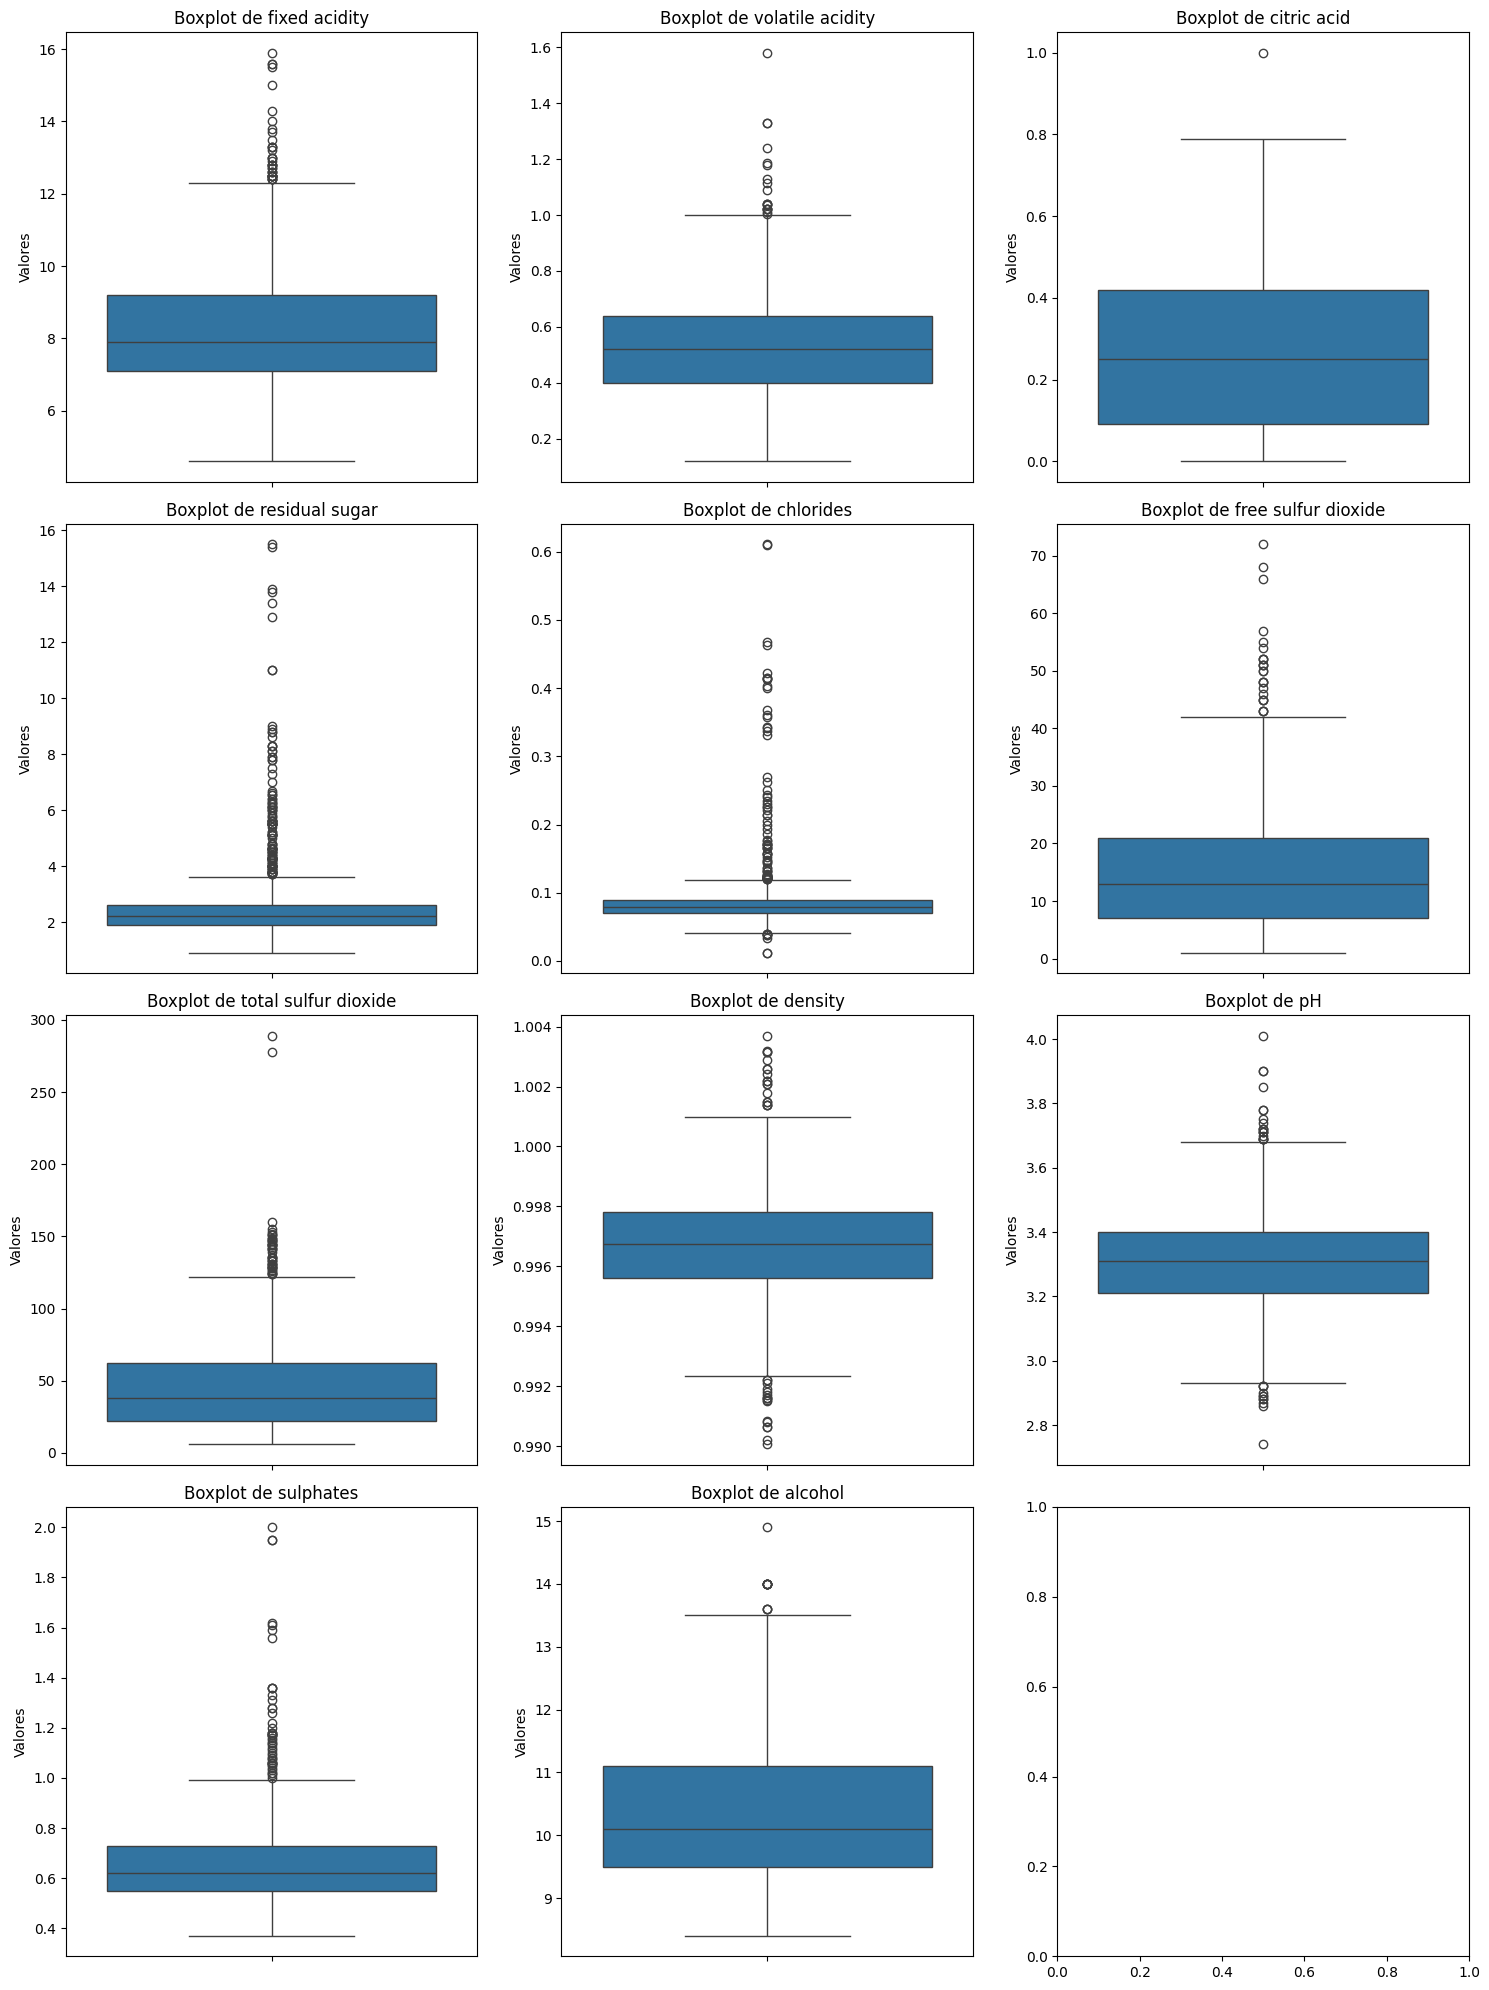

In [ ]:
#BOX PLOTS PARA BUSQUEDA DE OUTLIERS
total_plots = len(tintos.columns)
rows = (total_plots + 2) // 3
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))

for idx, column in enumerate(tintos.columns):
    ax = axes[idx // 3, idx % 3] if total_plots > 1 else axes
    sns.boxplot(y=column, data=tintos, ax=ax)
    ax.set_title(f'Boxplot de {column}')
    ax.set_ylabel('Valores')
    ax.set_xlabel(None)

plt.tight_layout()

plt.show()

<Axes: >

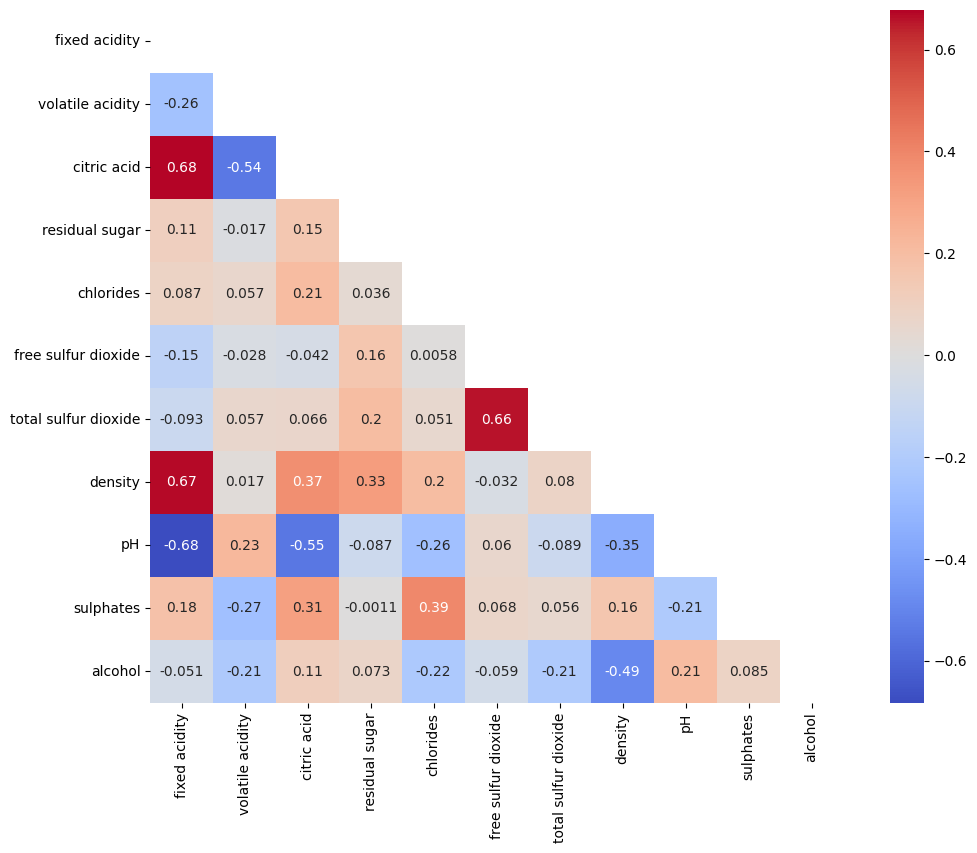

In [ ]:
corrmat = tintos.corr()
f, ax = plt.subplots(figsize=(12, 9))
mask = np.triu(np.ones_like(corrmat, dtype=bool))
sns.heatmap(corrmat, mask=mask, square=True, annot=True, cmap="coolwarm")

In [ ]:
#ESTANDARIZADO DE DATOS
scaler = StandardScaler()
tintos_scaled = scaler.fit_transform(tintos)

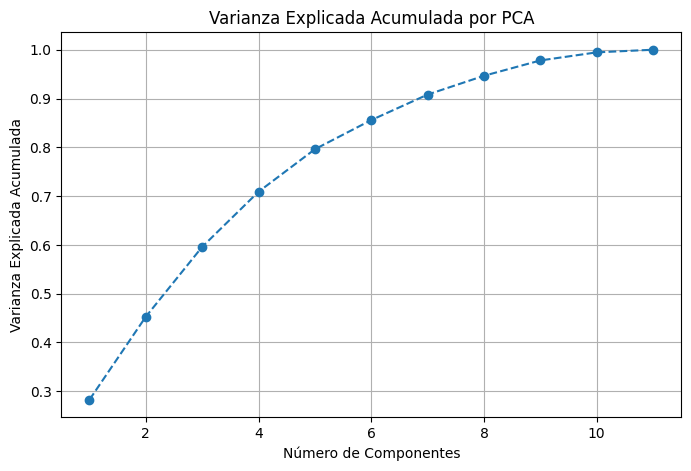

In [ ]:
# Inicializamos PCA sin especificar el número de componentes
pca = PCA()
pca.fit(tintos_scaled)

# Calculamos la varianza explicada acumulada
varianza_acumulada = np.cumsum(pca.explained_variance_ratio_)

# Graficamos la varianza explicada acumulada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(varianza_acumulada) + 1), varianza_acumulada, marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada por PCA')
plt.grid(True)
plt.show()

In [ ]:
#Elegimos 7 componentes por estar un poco por encima del 90%, aunque se podria elesgir 6
pca = PCA(n_components=7)
tintos_pca = pca.fit_transform(tintos_scaled)

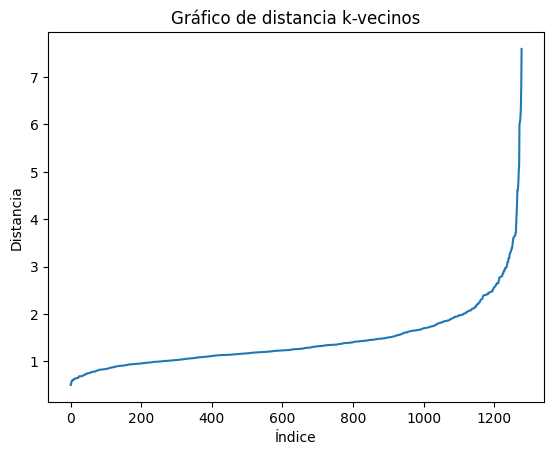

In [ ]:
# Ajustar el modelo para calcular distancias de los k-vecinos
neigh = NearestNeighbors(n_neighbors=10)
neigh.fit(tintos_pca)
distances, _ = neigh.kneighbors(tintos_pca)

# Ordenar y graficar las distancias
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.title("Gráfico de distancia k-vecinos")
plt.xlabel("Índice")
plt.ylabel("Distancia")
plt.show()

In [ ]:
#BUSQUEDA DEL MEJOR VALOR PARA DBSCAN
# Definir rangos para eps y min_samples
eps_values = np.arange(1.0, 3.0, 0.1)
min_samples_values = [5, 6, 7, 8, 9, 10, 11, 12, 15, 20]

# Variables para almacenar los mejores resultados
best_params = {"eps": None, "min_samples": None}
best_silhouette = -1
best_calinski = -1

print("Probando combinaciones de parámetros...")

# Bucle para probar diferentes combinaciones
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(tintos_pca)

        # Verificar si hay al menos 2 clústeres distintos (excluyendo -1)
        unique_labels = set(labels) - {-1}  # Elimina la etiqueta de ruido (-1)
        if len(unique_labels) < 2:
            print(f"eps={eps}, min_samples={min_samples}: Solo hay un clúster válido (o todo es ruido)")
            continue

        # Calcular coeficiente de silueta (excluye outliers con etiqueta -1)
        sil_score = silhouette_score(tintos_pca[labels != -1], labels[labels != -1])

        # Calcular índice de Calinski-Harabasz
        calinski_score = calinski_harabasz_score(tintos_pca, labels)

        print(f"eps={eps}, min_samples={min_samples}, Silueta={sil_score:.2f}, Calinski-Harabasz={calinski_score:.2f}")

        # Actualizar el mejor resultado basado en el coeficiente de silueta
        if sil_score > best_silhouette:
            best_silhouette = sil_score
            best_params["eps"] = eps
            best_params["min_samples"] = min_samples
            best_calinski = calinski_score

print("\nMejor combinación encontrada:")
print(f"eps={best_params['eps']}, min_samples={best_params['min_samples']}")
print(f"Coeficiente de Silueta: {best_silhouette:.2f}, Índice de Calinski-Harabasz: {best_calinski:.2f}")


Probando combinaciones de parámetros...
eps=1.0, min_samples=5, Silueta=-0.08, Calinski-Harabasz=14.21
eps=1.0, min_samples=6, Silueta=-0.13, Calinski-Harabasz=14.40
eps=1.0, min_samples=7, Silueta=-0.10, Calinski-Harabasz=14.05
eps=1.0, min_samples=8, Silueta=-0.11, Calinski-Harabasz=17.50
eps=1.0, min_samples=9, Silueta=-0.04, Calinski-Harabasz=24.77
eps=1.0, min_samples=10, Silueta=0.02, Calinski-Harabasz=29.59
eps=1.0, min_samples=11, Silueta=0.00, Calinski-Harabasz=21.51
eps=1.0, min_samples=12, Silueta=0.07, Calinski-Harabasz=22.46
eps=1.0, min_samples=15, Silueta=0.22, Calinski-Harabasz=36.48
eps=1.0, min_samples=20, Silueta=0.26, Calinski-Harabasz=32.97
eps=1.1, min_samples=5, Silueta=-0.08, Calinski-Harabasz=13.96
eps=1.1, min_samples=6, Silueta=-0.08, Calinski-Harabasz=14.97
eps=1.1, min_samples=7, Silueta=0.19, Calinski-Harabasz=30.44
eps=1.1, min_samples=8, Silueta=0.10, Calinski-Harabasz=27.79
eps=1.1, min_samples=9, Silueta=0.25, Calinski-Harabasz=35.03
eps=1.1, min_sampl

In [ ]:
#INICIALIZAR DBSCAN PARA BUSQUEDA DE OUTLIERS
eps = 1.9  # Radio de vecindad
min_samples = 9  # Mínimo número de puntos en la vecindad para formar un clúster

# Crear y ajustar el modelo
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(tintos_pca)

# Identificar los índices de los outliers
outlier_indices = np.where(labels == -1)[0]

# Extraer los outliers
outliers = tintos_pca[outlier_indices]

print(f"Número de outliers detectados: {len(outlier_indices)}")
print("Outliers:", outliers)

Número de outliers detectados: 98
Outliers: [[-4.71793162e-01  2.04729055e+00 -6.39591128e-01 -1.34203235e-01
   2.55672923e+00  8.40519242e-01 -1.15631651e-02]
 [ 7.41695633e-01  3.63370533e+00 -3.77064796e-01 -1.70769868e+00
   2.40329831e+00 -5.13034489e-01 -7.65499677e-01]
 [ 4.45242688e+00  2.07167437e-01  1.27273087e+00 -1.54631378e+00
   1.71157074e+00 -8.31177393e-01  1.85087407e+00]
 [ 4.32536553e-01  4.20295255e+00  1.07088081e+00 -1.03785581e-01
   6.56705757e-01  1.88799938e-01  2.12363403e-01]
 [ 9.45752647e-01  3.15075042e-01 -2.70229432e+00  1.71101154e+00
   1.09835396e+00 -2.62319365e-01 -9.84435660e-01]
 [ 2.64628495e+00  3.41104660e+00 -1.67773628e+00 -1.59778835e+00
   2.21376172e+00 -7.56128729e-02  1.02767352e+00]
 [-4.54996046e+00  2.48921608e+00  5.51764023e-01 -1.82786404e-02
  -3.57585126e-01 -2.73551283e-01  1.34713253e+00]
 [ 2.77272049e+00  2.08697866e+00 -9.03498096e-01 -3.09568264e+00
   4.08906117e+00  9.34286536e-01 -1.25054083e+00]
 [-2.05447100e+00  3

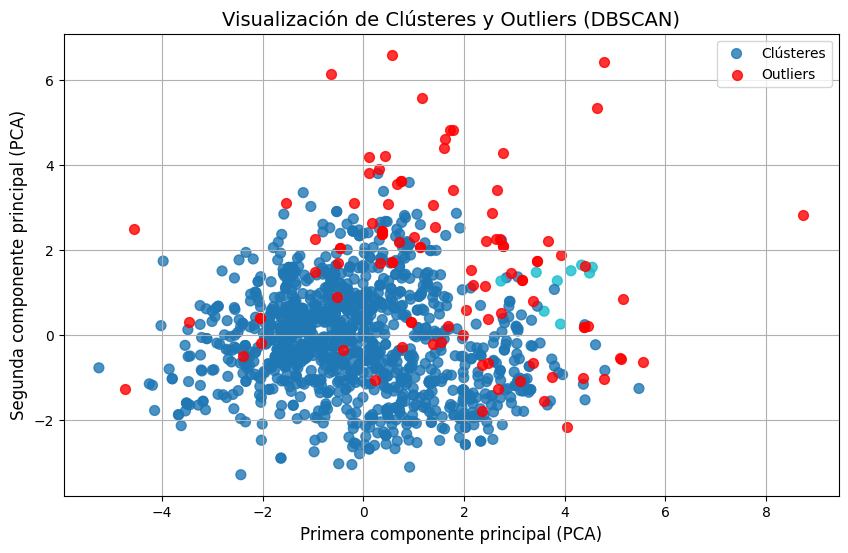

In [ ]:
#VISUALIZACION DE LOS OUTLIER DETECTADO EN 2D
# Reducir a 2 dimensiones para visualización
pca_2d = PCA(n_components=2)
tintos_pca_2d = pca_2d.fit_transform(tintos_pca)

# Ejecuta DBSCAN con los mejores parámetros
dbscan = DBSCAN(eps=1.9, min_samples=9)
labels = dbscan.fit_predict(tintos_pca)

# Crear una máscara para separar outliers y clústeres
outliers = (labels == -1)  # True para los outliers
clusters = ~outliers       # True para los puntos que pertenecen a clústeres

# Visualizar los datos en 2D (PCA reducido a 2 dimensiones)
plt.figure(figsize=(10, 6))

# Puntos de los clústeres
plt.scatter(tintos_pca_2d[clusters, 0], tintos_pca_2d[clusters, 1],
            c=labels[clusters], cmap='tab10', s=50, label='Clústeres', alpha=0.8)

# Puntos de los outliers
plt.scatter(tintos_pca_2d[outliers, 0], tintos_pca_2d[outliers, 1],
            c='red', s=50, label='Outliers', alpha=0.8)

plt.title("Visualización de Clústeres y Outliers (DBSCAN)", fontsize=14)
plt.xlabel("Primera componente principal (PCA)", fontsize=12)
plt.ylabel("Segunda componente principal (PCA)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Filtrar los puntos que no son outliers (etiquetas != -1)
tintos_sin_outliers = tintos_pca[labels != -1]

# Ahora `tintos_sin_outliers` contiene solo los puntos que no son outliers
print(f"Datos sin outliers: {tintos_sin_outliers.shape}")

Datos sin outliers: (1181, 7)


In [ ]:
# Método del codo para determinar el número óptimo de clústeres sin outliers
wcssb = []  # Suma de los cuadrados dentro de los clústeres
range_clusters = range(2, 30)
for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(tintos_sin_outliers)
    wcssb.append(kmeans.inertia_)


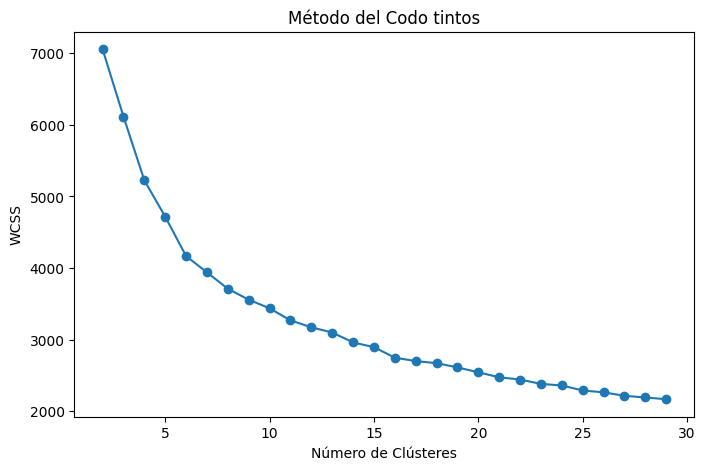

In [ ]:
# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, wcssb, marker='o')
plt.title('Método del Codo tintos')
plt.xlabel('Número de Clústeres')
plt.ylabel('WCSS')
plt.show()

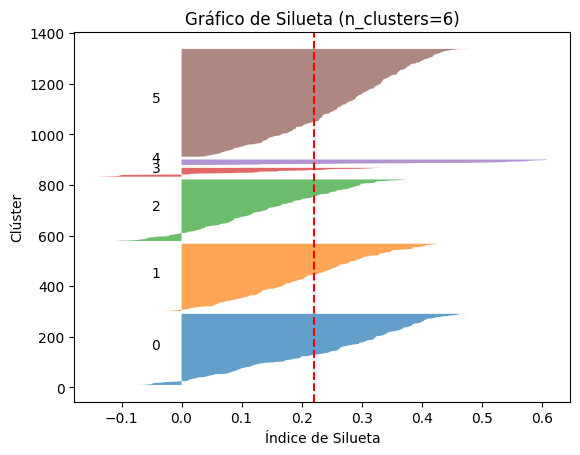

In [ ]:
# Datos para el clustering
X = tintos_pca

# Selecciona el número de clústeres
n_clusters = 6  # Cambia por el número de clústeres deseado

# Ajustar el modelo KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X)

# Calcular las puntuaciones de silueta para cada punto
silhouette_vals = silhouette_samples(X, labels)

# Crear el Silhouette Plot
def plot_silhouette(X, labels, silhouette_vals, n_clusters):
    y_lower = 10
    for i in range(n_clusters):
        # Puntuaciones de silueta del clúster actual
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()
        size_cluster_i = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i

        # Rellenar el gráfico
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # Dejar espacio entre clústeres

    # Dibujar la línea del índice de silueta promedio
    avg_score = np.mean(silhouette_vals)
    plt.axvline(avg_score, color="red", linestyle="--")

    plt.xlabel("Índice de Silueta")
    plt.ylabel("Clúster")
    plt.title(f"Gráfico de Silueta (n_clusters={n_clusters})")
    plt.show()

# Llamar a la función para graficar
plot_silhouette(X, labels, silhouette_vals, n_clusters)

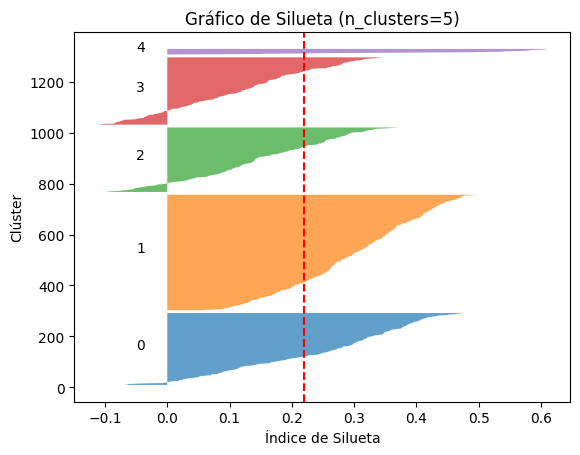

In [ ]:
# Datos para el clustering
X = tintos_pca

# Selecciona el número de clústeres
n_clusters = 5  # Cambia por el número de clústeres deseado

# Ajustar el modelo KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X)

# Calcular las puntuaciones de silueta para cada punto
silhouette_vals = silhouette_samples(X, labels)

# Crear el Silhouette Plot
def plot_silhouette(X, labels, silhouette_vals, n_clusters):
    y_lower = 10
    for i in range(n_clusters):
        # Puntuaciones de silueta del clúster actual
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()
        size_cluster_i = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i

        # Rellenar el gráfico
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # Dejar espacio entre clústeres

    # Dibujar la línea del índice de silueta promedio
    avg_score = np.mean(silhouette_vals)
    plt.axvline(avg_score, color="red", linestyle="--")

    plt.xlabel("Índice de Silueta")
    plt.ylabel("Clúster")
    plt.title(f"Gráfico de Silueta (n_clusters={n_clusters})")
    plt.show()

# Llamar a la función para graficar
plot_silhouette(X, labels, silhouette_vals, n_clusters)

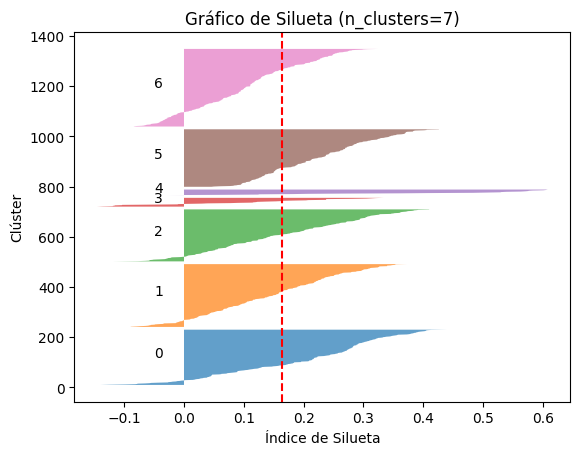

In [ ]:
# Datos para el clustering
X = tintos_pca

# Selecciona el número de clústeres
n_clusters = 7  # Cambia por el número de clústeres deseado

# Ajustar el modelo KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X)

# Calcular las puntuaciones de silueta para cada punto
silhouette_vals = silhouette_samples(X, labels)

# Crear el Silhouette Plot
def plot_silhouette(X, labels, silhouette_vals, n_clusters):
    y_lower = 10
    for i in range(n_clusters):
        # Puntuaciones de silueta del clúster actual
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()
        size_cluster_i = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i

        # Rellenar el gráfico
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # Dejar espacio entre clústeres

    # Dibujar la línea del índice de silueta promedio
    avg_score = np.mean(silhouette_vals)
    plt.axvline(avg_score, color="red", linestyle="--")

    plt.xlabel("Índice de Silueta")
    plt.ylabel("Clúster")
    plt.title(f"Gráfico de Silueta (n_clusters={n_clusters})")
    plt.show()

# Llamar a la función para graficar
plot_silhouette(X, labels, silhouette_vals, n_clusters)

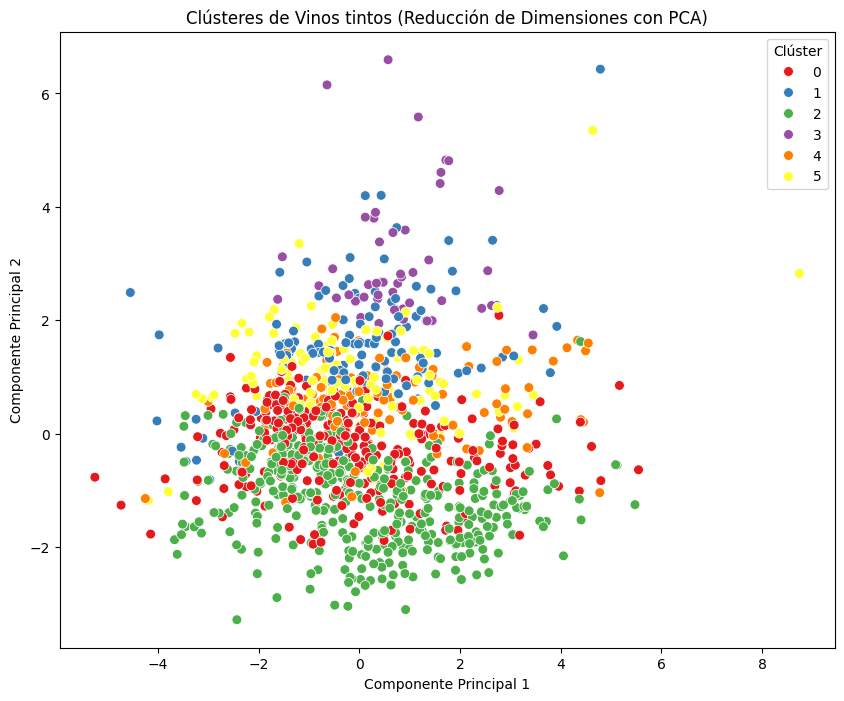

Características promedio por clúster:
         fixed acidity  volatile acidity  citric acid  residual sugar  \
Cluster                                                                 
0             8.258790          0.527349     0.243948        2.423343   
1             7.777465          0.580211     0.259930        3.010563   
2             8.566176          0.520011     0.278676        2.445378   
3             8.053571          0.560714     0.333393        3.457143   
4             8.315873          0.548056     0.287778        2.440476   
5             8.192424          0.495795     0.262121        2.453030   

         chlorides  free sulfur dioxide  total sulfur dioxide   density  \
Cluster                                                                   
0         0.083980            15.295389             38.443804  0.996708   
1         0.087127            22.633803             96.007042  0.996788   
2         0.084164             7.455882             18.415966  0.996602   
3 

In [ ]:
# Aplicar K-means con 6 clústeres
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(tintos)

# Agregar los clústeres como una nueva columna en los datos originales
tintos['Cluster'] = clusters

# Visualización de clústeres en dos dimensiones PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tintos_pca)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=tintos['Cluster'], palette="Set1", s=50)
plt.title("Clústeres de Vinos tintos (Reducción de Dimensiones con PCA)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Clúster")
plt.show()

# Análisis de las características promedio por clúster
cluster_means_b = tintos.groupby('Cluster').mean()
print("Características promedio por clúster:")
print(cluster_means_b)

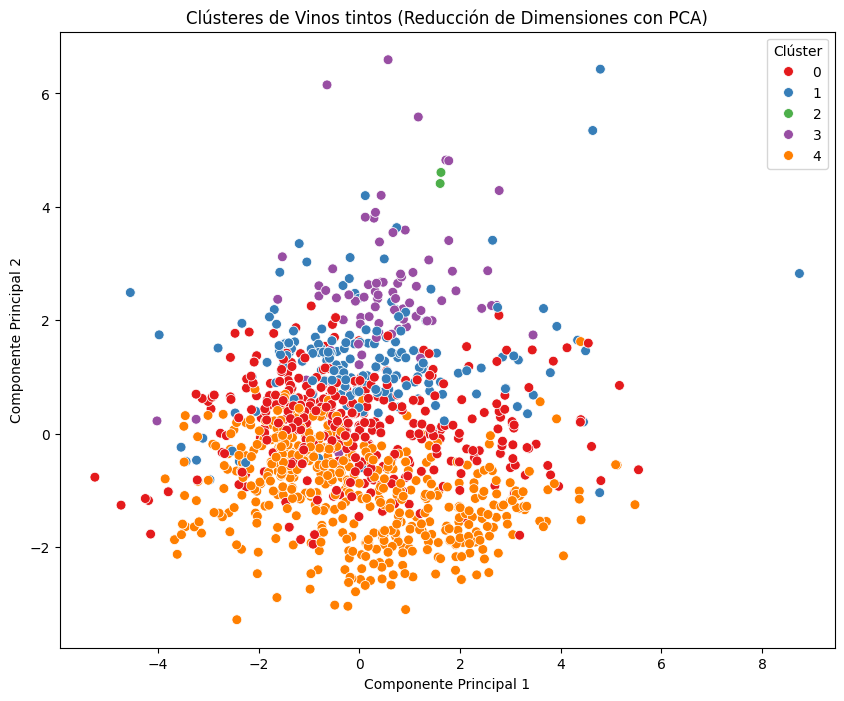

Características promedio por clúster:
         fixed acidity  volatile acidity  citric acid  residual sugar  \
Cluster                                                                 
0             8.225485          0.523410     0.257209        2.448180   
1             8.150000          0.544442     0.289029        2.832767   
2             7.900000          0.300000     0.680000        8.300000   
3             7.991860          0.564419     0.300116        3.237791   
4             8.476440          0.526815     0.263630        2.391012   

         chlorides  free sulfur dioxide  total sulfur dioxide   density  \
Cluster                                                                   
0         0.089010            19.057039             47.155340  0.996761   
1         0.091670            24.635922             81.793689  0.997025   
2         0.050000            37.500000            283.500000  0.993160   
3         0.090988            28.883721            126.069767  0.997124   


In [ ]:
# Aplicar K-means con 5 clústeres
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(tintos)

# Agregar los clústeres como una nueva columna en los datos originales
tintos['Cluster'] = clusters

# Visualización de clústeres en dos dimensiones PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tintos_pca)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=tintos['Cluster'], palette="Set1", s=50)
plt.title("Clústeres de Vinos tintos (Reducción de Dimensiones con PCA)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Clúster")
plt.show()

# Análisis de las características promedio por clúster
cluster_means_b = tintos.groupby('Cluster').mean()
print("Características promedio por clúster:")
print(cluster_means_b)

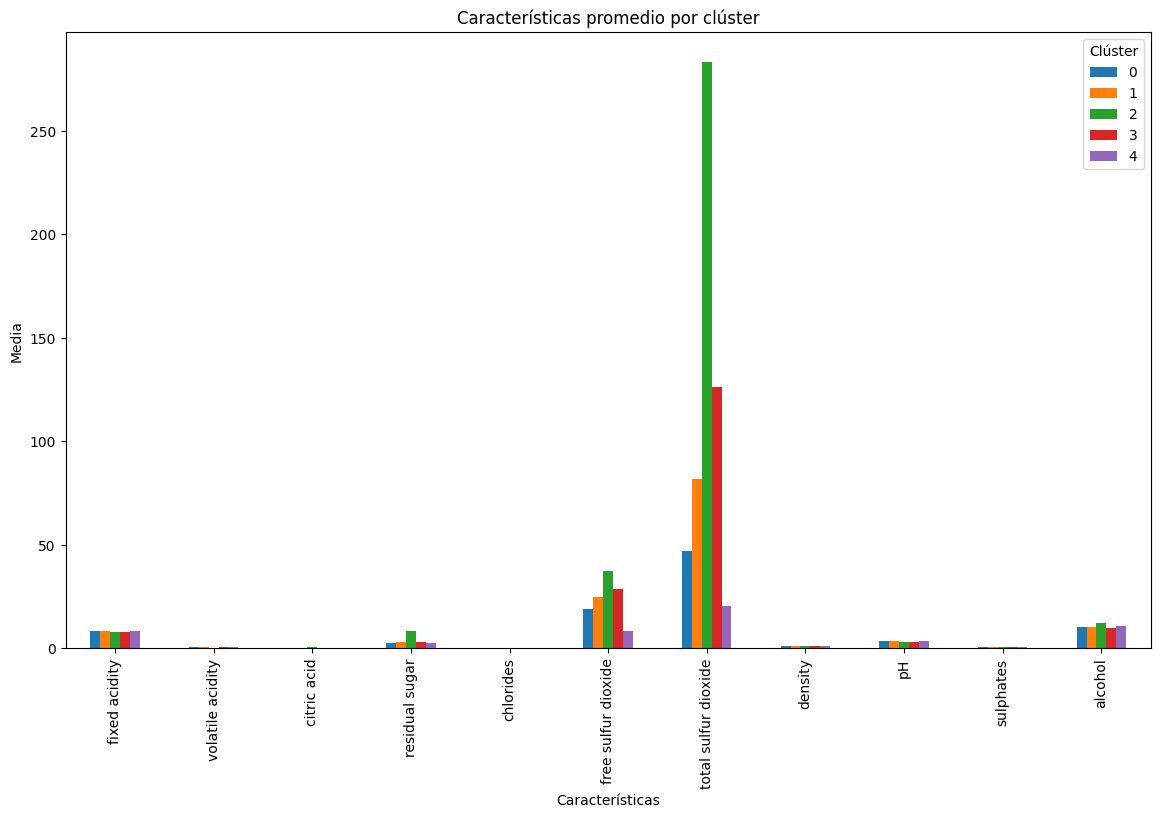

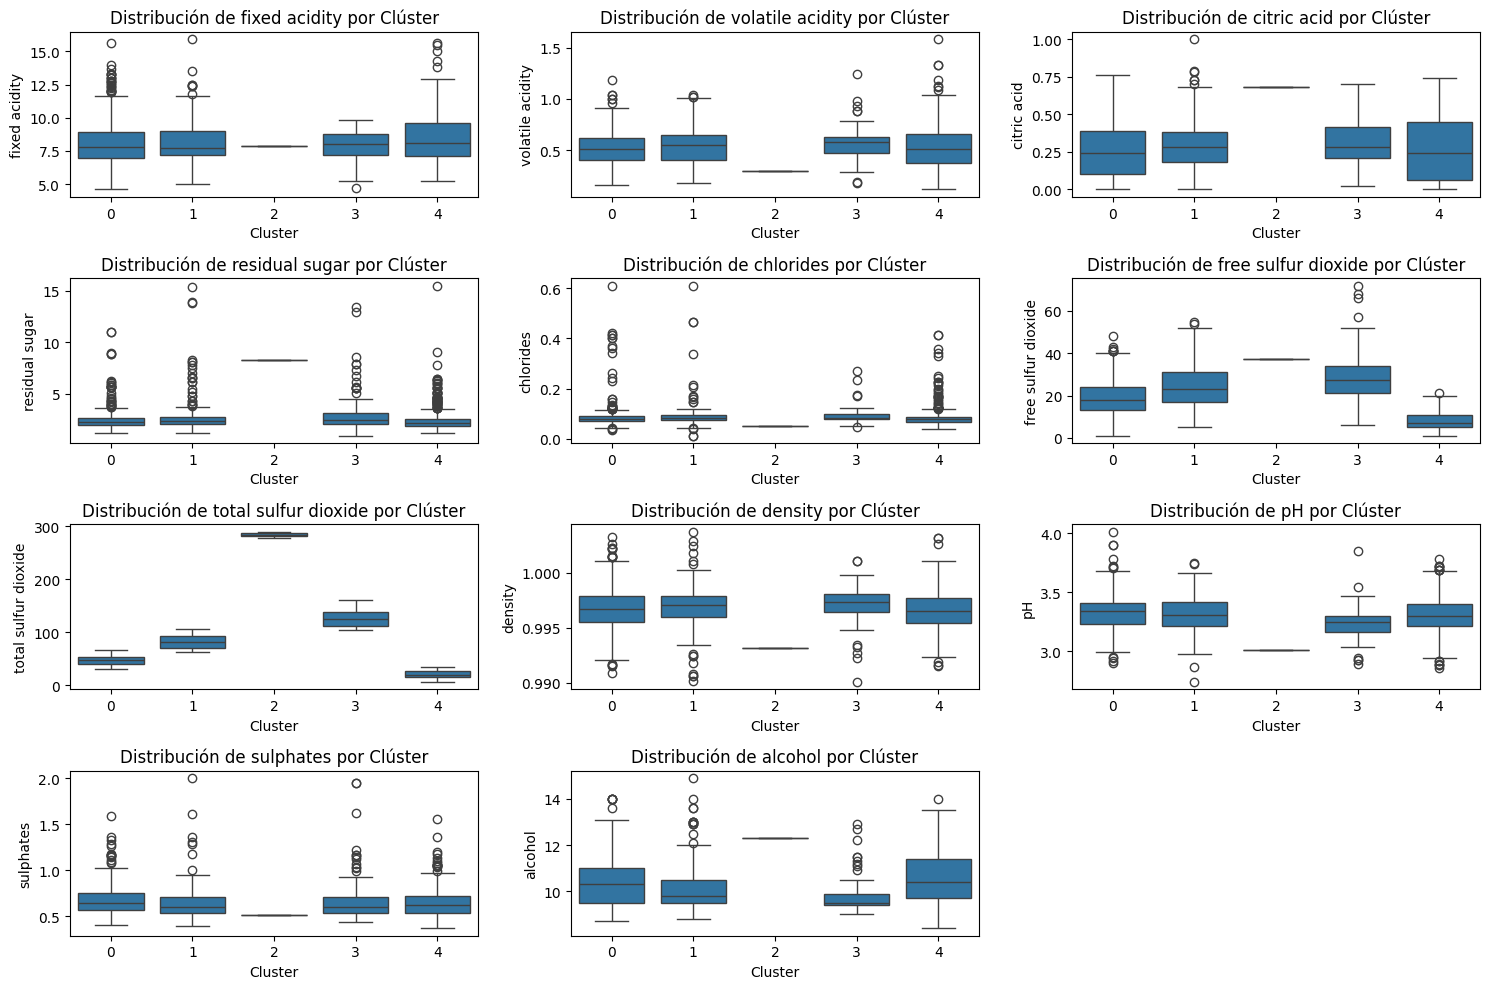

In [ ]:
# Gráfico de barras de las características promedio por clúster
cluster_means_b.T.plot(kind='bar', figsize=(14, 8))
plt.title("Características promedio por clúster")
plt.ylabel("Media")
plt.xlabel("Características")
plt.legend(title="Clúster")
plt.show()

# Gráfico de cajas para ver la distribución de cada característica por clúster
plt.figure(figsize=(15, 10))
for i, column in enumerate(tintos.columns[:-1], 1):  # Excluyendo la columna 'Cluster'
    plt.subplot(4, 3, i)
    sns.boxplot(data=tintos, x='Cluster', y=column)
    plt.title(f"Distribución de {column} por Clúster")
plt.tight_layout()
plt.show()

In [ ]:
def clustering_tintos(df,):

    # Crear el modelo KMeans
    kmeans = KMeans(n_clusters=5, random_state=0)

    # Ajustar el modelo y predecir los clústeres
    clusters = kmeans.fit_predict(df)

    # Agregar los clústeres como una nueva columna
    df['Cluster'] = clusters

    return df

tintos_clustered = clustering_tintos(tintos)
print(tintos_clustered)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               6.8              0.69         0.00            5.60      0.124   
1              13.3              0.43         0.58            1.90      0.070   
2               6.4              0.69         0.00            1.65      0.055   
3               9.9              0.53         0.57            2.40      0.093   
4               7.6              0.42         0.25            3.90      0.104   
...             ...               ...          ...             ...        ...   
1274            8.4              0.31         0.29            3.10      0.194   
1275           10.2              0.23         0.37            2.20      0.057   
1276            7.4              0.53         0.12            1.90      0.165   
1277            7.4              0.55         0.19            1.80      0.082   
1278            8.2              0.78         0.00            2.20      0.089   

      free sulfur dioxide  